# Classifying a Single Target

This notebook demonstrates the photometric classification of a single supernova (SN) from the Carnegie Supernova Project (CSP). It is a simplified example intended to outline the general classification technique introduced by González-Gaitán et al. 2014. Two approaches are demonstrated in this notebook. In the frist, data is split into rest frame red and rest frame blue bandpasses. Fits are then performed in the blue using the entire blue data set and then again in the red. The second approach fits each band independently and then seperates results into red and blue bands afterwords. Chi-squareds are then summed for the blue and red bands.

#### Table of Contents:
1. <a href='#fitting_collectively'>Fitting Bands Collectively</a>: Classification performed by fitting blue and red data as seperate band sets.
1. <a href='#fitting_independently'>Fitting Bands Independently</a>: Classification performed by fitting bands independently and then seperating results into the blue and red afterword.


In [1]:
import sys

import sncosmo
from matplotlib import pyplot as plt
from sndata.csp import dr3

sys.path.insert(0, '../')
from phot_class import models
from phot_class import utils
from phot_class.fit_funcs import simple_fit
from phot_class.classification import run_classification_fits

dr3.download_module_data()
dr3.register_filters(force=True)
models.register_sources(force=True)


## Fitting Bands Collectively <a id='fitting_collectively'></a>

We start by reading in data for an arbitrarily chosen SN. For demonstration purposes, we pick a known 91bg-like SN and drop band-passes that are outside the wavelength range of the salt2 model. 

In [2]:
demo_id = '2005ke'
all_data = dr3.get_data_for_id(demo_id)
all_data = all_data[all_data['band'] != 'csp_dr3_Y']
all_data = all_data[all_data['band'] != 'csp_dr3_Ydw']
all_data = all_data[all_data['band'] != 'csp_dr3_J']
all_data = all_data[all_data['band'] != 'csp_dr3_H']


Using the spectroscopic redshift of the target, we split the photometric data into rest frame blue and red wavelengths. In practice, we may not have the redshift value and will need to split data using a photometrically determined redshift.

In [3]:
redshift = all_data.meta['redshift']
blue_data, red_data = utils.split_data(
    all_data, dr3.band_names, dr3.lambda_effective, redshift)

print('Blue data bands:', set(blue_data['band']))
print('Red data bands :', set(red_data['band']))


Blue data bands: {'csp_dr3_V0', 'csp_dr3_V', 'csp_dr3_g', 'csp_dr3_B', 'csp_dr3_u'}
Red data bands : {'csp_dr3_r', 'csp_dr3_i'}


Next, we fit the red and blue data using models for salt2-like and 91bg-like SNe. Naively this results in four total light-curve fits; however, we also perform an initial fit using the complete light-curve and the salt2 model. This additional fit helps us determine an initial guess for the time of maximum and ensures more predictable fitting results.


In [20]:
sn91bg = sncosmo.Model('sn91bg')
salt2 = sncosmo.Model('salt2')

initial_result, _ = simple_fit(all_data, salt2, ['t0', 'x0', 'x1', 'c'])
t0 = initial_result.parameters[1]

salt2.set(t0=t0, z=redshift)
salt2_bounds = {'t0': (t0 - 3, t0 + 3)}

sn91bg.set(t0=t0, z=redshift)
sn91bg_bounds = {
    't0': (t0 - 3, t0 + 3), 
    'x1': (0.65, 1.25),
    'c': (0, 1)}

blue_salt2_result, blue_salt2_fit = simple_fit(blue_data, salt2, ['t0', 'x0', 'x1', 'c'], bounds=salt2_bounds)
red_salt2_result, red_salt2_fit = simple_fit(red_data, salt2, ['t0', 'x0', 'x1', 'c'], bounds=salt2_bounds)

blue_sn91bg_result, blue_sn91bg_fit = simple_fit(blue_data, sn91bg, ['t0', 'amplitude', 'x1', 'c'], bounds=sn91bg_bounds)
red_sn91bg_result, red_sn91bg_fit = simple_fit(red_data, sn91bg, ['t0', 'amplitude', 'x1', 'c'], bounds=sn91bg_bounds)


We pause here to visually inspect the fit results.

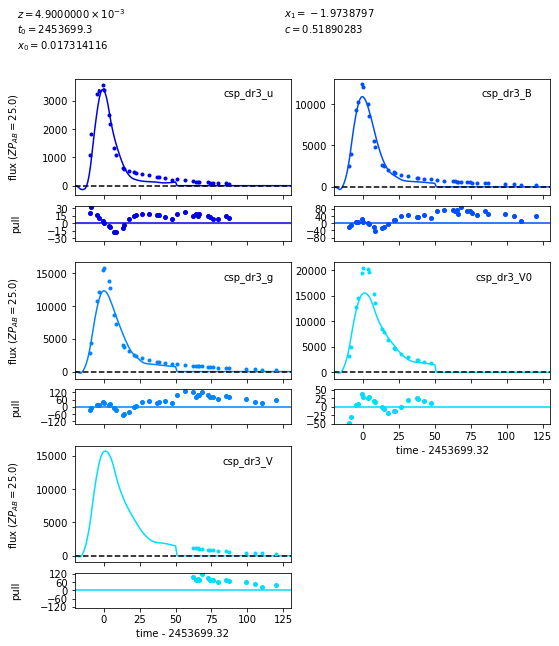

In [21]:
sncosmo.plot_lc(blue_data, blue_salt2_fit)
# sncosmo.plot_lc(red_data, red_salt2_fit)
# sncosmo.plot_lc(blue_data, blue_sn91bg_fit)
# sncosmo.plot_lc(red_data, red_sn91bg_fit)
plt.show()


Finally, we determine the chi-squared of each fit and use them to determine a classification coordinate. If we were to repeat this process for multiple SNe and plot the resulting coordinates, we would expect 91bg like SNe to fall in the upper right quadrant and salt2-like SNe to fall in the lower-left corner (see González-Gaitán et al. 2014 for more details). Since our example light curve is from a 91bg-like SN, we expect a positive x and y coordinate.

In [18]:
blue_sn91bg_chisq, blue_sn91bg_dof = utils.calc_model_chisq(blue_data, blue_salt2_result, blue_salt2_fit)
red_sn91bg_chisq, red_sn91bg_dof = utils.calc_model_chisq(red_data, red_salt2_result, red_salt2_fit)

blue_salt2_chisq, blue_salt2_dof = utils.calc_model_chisq(blue_data, blue_sn91bg_result, blue_sn91bg_fit)
red_salt2_chisq, red_salt2_dof = utils.calc_model_chisq(red_data, red_sn91bg_result, red_sn91bg_fit)

classification = (
    (blue_salt2_chisq / blue_salt2_dof) - (blue_sn91bg_chisq / blue_sn91bg_dof), 
    (red_salt2_chisq / red_salt2_dof) - (red_sn91bg_chisq / red_sn91bg_dof)
)

classification


(-565.4869814091461, -1373.3836873058767)

## Fitting Bands Independently <a id='fitting_independently'></a>

In [19]:
run_classification_fits(demo_id, all_data, ['t0', 'amplitude', 'x1', 'c'], simple_fit, )

TypeError: run_classification_fits() missing 4 required positional arguments: 'obj_id', 'data', 'vparams', and 'fit_func'